# Continuum plots

Loads depth-frequency-time PSD data and then plots continuum for various analyses.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import cmocean
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import pandas as pd
import matplotlib.dates as pldates
import matplotlib.colors as colors
import matplotlib.pylab as pl
from matplotlib import cm
from scipy.stats import chi2
from scipy.optimize import curve_fit
for i in range(2):
    %matplotlib notebook

In [2]:
# import data

adcp = 'Slope'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018), Shoulder
year = 2013

if adcp == 'Shoulder':
    adcp2 = 'Slope'
    ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp2}_1min_{year}_0.nc')
    n_seg = ds_in.n_seg
    ds = [ds_in]
    if n_seg > 1:
        for i in range(n_seg):
            if i > 0:
                ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp2}_1min_{year}_{i}.nc')
                ds.append(ds_temp)
else:
    ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')
    n_seg = ds_in.n_seg
    ds = [ds_in]
    if n_seg > 1:
        for i in range(n_seg):
            if i > 0:
                ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
                ds.append(ds_temp)

#print(ds[0].attrs)
#rint(ds[0].Sxxu_d)

In [3]:
# extract plotting variables & GM

t_stamp = int(ds[0].t_stamp)
depth = ds[0].depth.values

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')     # get GM data from separate code
gm_freq = np.asarray(gm[176:246,0])/(2*np.pi)       # GM frequency range (7e-5 to 1.2e-4)
gm_psd = np.asarray(gm[176:246,1])*(np.pi)          # 1/2 GM amplitudes
gmpw = gm_psd * (gm_freq**2)                        # whiten
gmp_psd_avg = np.nanmean(gm_psd)                    # GM non-whitened amplitude
gmp_avg = np.nanmean(gmpw)                          # GM whitened 'c' value.

gm_pl_a = 2.66846761e-09
gm_pl_b = -2.11893588

print('1/2 GM amplitude (non-whitened):',gmp_psd_avg)
print('1/2 GM amplitude (whitened):',gmp_avg)
print('1/2 GM amplitude (power law fit):',gm_pl_a)
print('1/2 GM slope (power law fit):',gm_pl_b)
print('GM freq. range:',gm_freq[0],gm_freq[-1])

1/2 GM amplitude (non-whitened): 1.015225233124031
1/2 GM amplitude (whitened): 8.068588316559413e-09
1/2 GM amplitude (power law fit): 2.66846761e-09
1/2 GM slope (power law fit): -2.11893588
GM freq. range: 6.997905863136765e-05 0.0001199683775138179


## Continuum fits (a, b)

In [ ]:
# set depth, WKB, freq range

start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

if adcp == 'Slope':
    didx = -11                   # -1 for lower depth, -20 for mid-depth
elif adcp == 'Axis75':
    didx = -12
elif adcp == 'Axis55':
    didx = -5
    
phi_u,phi_v = [],[]
for i in range(n_seg):
    phi_u.append( ds[i].Sxxu_c[didx] )
    phi_v.append( ds[i].Sxxv_c[didx] )
    
d_stamp = ds[0].depth[didx].values
print('Depth:',-d_stamp,'m')

# WKB scale

WKB_u,WKB_v = [],[]
for i in range(n_seg):
    WKB_u.append( phi_u[i] / ds[0].WKB_scale[didx] )
    WKB_v.append( phi_v[i] / ds[0].WKB_scale[didx] )
                 
# continuum freq range

lowf = 16                    # set frequency range for continuum
highf = 28

frequencies = WKB_u[0].specf_c.values
f_range = frequencies[lowf:highf]      # set data range for continuum
print('Continuum freq. range:',f_range[0],f_range[-1])

In [ ]:
# continuum fits (7e-5 to 1.2e-4 Hz)

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

ua,ub,va,vb = [],[],[],[]

gmpars, gmcov = curve_fit(f=power_law, xdata=gm_freq, ydata=gm_psd, p0=[2.5e-9, -2], bounds=([1e-9,-3],[5e-9,-1]),maxfev=1000)

for i in range(n_seg):
    uax,ubx,vax,vbx = [],[],[],[]
    #u_cx,v_cx = [],[]
    for j in range(len(WKB_u[i].spect_c)):
        u_range_temp = WKB_u[i][lowf:highf,j].values
        v_range_temp = WKB_v[i][lowf:highf,j].values
        # Fit the power-law data
        upars, ucov = curve_fit(f=power_law, xdata=f_range, ydata=u_range_temp, p0=[2.5e-9, -2], bounds=([1e-9,-3],[5e-9,-1]),maxfev=1000)
        vpars, vcov = curve_fit(f=power_law, xdata=f_range, ydata=v_range_temp, p0=[2.5e-9, -2], bounds=([1e-9,-3],[5e-9,-1]),maxfev=1000)
        #upars, ucov = curve_fit(f=power_law, xdata=f_range, ydata=u_range_temp, p0=[2.5e-9, -2], bounds=([1e-9,-3],[1e-8,-1]),maxfev=1000)
        #vpars, vcov = curve_fit(f=power_law, xdata=f_range, ydata=v_range_temp, p0=[2.5e-9, -2], bounds=([1e-9,-3],[1e-8,-1]),maxfev=1000)
        uax.append(upars[0])       # get a and b coefficients
        ubx.append(upars[1])
        vax.append(vpars[0])
        vbx.append(vpars[1])
    ua.append(uax)       # get a and b coefficients
    ub.append(ubx)
    va.append(vax)
    vb.append(vbx)
    #u_cx.append(u_range_temp)
    #v_cx.append(v_range_temp)

In [ ]:
print(f'GM power law fit: {gmpars}')

In [ ]:
# average a and b data

n_avg = 11
n_avg2 = 5
dua_roll_ua,dub_roll_ub,dva_roll_va,dvb_roll_vb = [],[],[],[]
for i in range(n_seg):
    dua = xr.Dataset(
            data_vars=dict(
                ua = (['time'],ua[i]),
                ub = (['time'],ub[i]),
                va = (['time'],va[i]),
                vb = (['time'],vb[i]),
            ),
            coords=dict(
                time = WKB_u[i].spect_c.values,
            ))
    for i in range(1):
        if len(dua.time) < n_avg:
            continue
        elif len(dua.time) >= n_avg:
            dua_roll_time_ua = dua.ua.rolling(time=n_avg,center=True).mean().dropna('time')
            dub_roll_time_ub = dua.ub.rolling(time=n_avg,center=True).mean().dropna('time')
            dva_roll_time_va = dua.va.rolling(time=n_avg,center=True).mean().dropna('time')
            dvb_roll_time_vb = dua.vb.rolling(time=n_avg,center=True).mean().dropna('time')
    for i in range(1):
        if len(dua_roll_time_ua.time) < n_avg2:
            continue
        elif len(dua_roll_time_ua.time) >= n_avg2:
            dua_roll_time_ua = dua_roll_time_ua.rolling(time=n_avg2,center=True).mean().dropna('time')
            dub_roll_time_ub = dub_roll_time_ub.rolling(time=n_avg2,center=True).mean().dropna('time')
            dva_roll_time_va = dva_roll_time_va.rolling(time=n_avg2,center=True).mean().dropna('time')
            dvb_roll_time_vb = dvb_roll_time_vb.rolling(time=n_avg2,center=True).mean().dropna('time')
    dua_roll_ua.append(dua_roll_time_ua)
    dub_roll_ub.append(dub_roll_time_ub)
    dva_roll_va.append(dva_roll_time_va)
    dvb_roll_vb.append(dvb_roll_time_vb)

In [ ]:
# plot a values

fig,ax = plt.subplots(1,1,figsize=(12,3))

ax.set_title(fr'Power law ($af^b$) amplitudes - {adcp} (-{d_stamp} m) - {year}',fontsize=14)
ax.set_xlabel('Time [months]',fontsize=14)
ax.set_ylabel(r'$a$',fontsize=14)  # (m/s)^2 ???
ax.tick_params(labelsize=14)

for i in range(n_seg):
    if i == 0:
        if adcp == 'Slope':
            #ax.plot(time[i],ua[i],label='Cross-slope',color='tab:blue')
            #ax.plot(time[i],va[i],label='Along-slope',color='tab:orange')
            ax.plot(dua_roll_ua[i].time,dua_roll_ua[i],label='Cross-slope',color='tab:blue')
            ax.plot(dva_roll_va[i].time,dva_roll_va[i],label='Along-slope',color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(dua_roll_ua[i].time,dua_roll_ua[i],label='Cross-canyon',color='tab:blue')
            ax.plot(dva_roll_va[i].time,dva_roll_va[i],label='Along-canyon',color='tab:orange')
    elif i > 0:
        if adcp == 'Slope':
            #ax.plot(time[i],ua[i],color='tab:blue')
            #ax.plot(time[i],va[i],color='tab:orange')
            ax.plot(dua_roll_ua[i].time,dua_roll_ua[i],color='tab:blue')
            ax.plot(dva_roll_va[i].time,dva_roll_va[i],color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(dua_roll_ua[i].time,dua_roll_ua[i],color='tab:blue')
            ax.plot(dva_roll_va[i].time,dva_roll_va[i],color='tab:orange')

ax.set_yscale('log')
ax.set_xlim(start_date,end_date)
#ax.set_ylim(1e-8,1e-6)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)

ax.plot([start_date,end_date],[gmpars[0],gmpars[0]],color='black',ls='--',lw=1,label='1/2 GM')

fig.tight_layout()
plt.legend(fontsize=14,loc=[0.24,0.84],frameon=False,ncol=3)
plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_a_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# plot b values

fig,ax = plt.subplots(1,1,figsize=(12,3))

ax.set_title(fr'Power law ($af^b$) slopes - {adcp} (-{d_stamp} m) - {year}',fontsize=14)
ax.set_xlabel('Time [months]',fontsize=14)
ax.set_ylabel(r'$b$',fontsize=14)
ax.tick_params(labelsize=14)

for i in range(n_seg):
    if i == 0:
        if adcp == 'Slope':
            #ax.plot(time[i],ub[i],label='Cross-slope',color='tab:blue')
            #ax.plot(time[i],vb[i],label='Along-slope',color='tab:orange')
            ax.plot(dub_roll_ub[i].time,dub_roll_ub[i],label='Cross-slope',color='tab:blue')
            ax.plot(dvb_roll_vb[i].time,dvb_roll_vb[i],label='Along-slope',color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            #ax.plot(time[i],ub[i],label='Cross-canyon',color='tab:blue')
            #ax.plot(time[i],vb[i],label='Along-canyon',color='tab:orange')
            ax.plot(dub_roll_ub[i].time,dub_roll_ub[i],label='Cross-canyon',color='tab:blue')
            ax.plot(dvb_roll_vb[i].time,dvb_roll_vb[i],label='Along-canyon',color='tab:orange')
    elif i > 0:
        if adcp == 'Slope':
            #ax.plot(time[i],ub[i],color='tab:blue')
            #ax.plot(time[i],vb[i],color='tab:orange')
            ax.plot(dub_roll_ub[i].time,dub_roll_ub[i],color='tab:blue')
            ax.plot(dvb_roll_vb[i].time,dvb_roll_vb[i],color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(dub_roll_ub[i].time,dub_roll_ub[i],color='tab:blue')
            ax.plot(dvb_roll_vb[i].time,dvb_roll_vb[i],color='tab:orange')
            
ax.set_xlim(start_date,end_date)
#ax.set_ylim(-2.5,-1.5)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)

ax.plot([start_date,end_date],[gmpars[1],gmpars[1]],color='black',ls='--',lw=1,label='1/2 GM')

fig.tight_layout()
plt.legend(fontsize=14,loc=[0.24,0.84],frameon=False,ncol=3)
plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_b_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save to .nc for inter-annual comparison

for i in range(n_seg):
    du_ab = xr.Dataset(
            data_vars=dict(
                ua = (['time'],dua_roll_ua[i]),
                ub = (['time'],dub_roll_ub[i]),
                va = (['time'],dva_roll_va[i]),
                vb = (['time'],dvb_roll_vb[i]),
            ),
            coords=dict(
                time = dub_roll_ub[i].time.values,
            ),
            attrs=dict(
                description=f'a and b data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
                adcp=adcp,                   # adcp
                #upidx=upidx,                 # upper depth index
                #lowidx=lowidx,               # lower depth index
                #dup_stamp=dup_stamp,         # upper depth stamp
                #dlow_stamp=dlow_stamp,       # lower depth stamp
                t_stamp=t_stamp,             # year stamp
                start_date=f'{start_date}',  # start date
                end_date=f'{end_date}',      # end date
                #t=t,                         # length of time series
                #d=d,                         # length of depth series
                n_seg=n_seg,                 # total number of segments
            ),
    )
    du_ab.to_netcdf(f'../Data/interannual/cont_ab_{adcp}_{t_stamp}_{i}.nc')

## Inter-annual ab comparisons

In [ ]:
# load ab data

site = 'Slope'

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/cont_ab_Slope_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/cont_ab_Slope_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/cont_ab_Slope_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/cont_ab_Slope_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/cont_ab_Slope_2018_0.nc'))
    lbl = 'slope'
    dlbl = '-300 m'
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/cont_ab_Axis55_2018_3.nc'))
    lbl = 'canyon'
    dlbl = '-900 m'
years = [ds_2013,ds_2014,ds_2017,ds_2018]

In [ ]:
# plot ab data

fig,((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2,figsize=(12,7),sharex=False,sharey=False)
axes = [ax0,ax2,ax4,ax6]
axes2 = [ax1,ax3,ax5,ax7]
fig.subplots_adjust(wspace=0.08)

for i,j in enumerate(years):
    for k in range(j[0].n_seg):
        if k == 0:
            axes[i].plot(j[k].time,j[k].ua,color='tab:blue',label=f'Cross-{lbl}')
            axes[i].plot(j[k].time,j[k].va,color='tab:orange',label=f'Along-{lbl}')
            axes[i].set_xlim(np.datetime64(f'{j[k].t_stamp}-01-01'),np.datetime64(f'{str(int(j[k].t_stamp)+1)}-01-01'))
            axes2[i].plot(j[k].time,j[k].ub,color='tab:blue',label=f'Cross-{lbl}')
            axes2[i].plot(j[k].time,j[k].vb,color='tab:orange',label=f'Along-{lbl}')
            axes2[i].set_xlim(np.datetime64(f'{j[k].t_stamp}-01-01'),np.datetime64(f'{str(int(j[k].t_stamp)+1)}-01-01'))
        elif k > 0:
            axes[i].plot(j[k].time,j[k].ua,color='tab:blue')
            axes[i].plot(j[k].time,j[k].va,color='tab:orange')
            axes2[i].plot(j[k].time,j[k].ub,color='tab:blue')
            axes2[i].plot(j[k].time,j[k].vb,color='tab:orange')

fig.text(0.513,0.91,f'{site} ({dlbl})',ha='center',fontsize=14)
#fig.text(0.272,0.283, r'GM$_{0.5}$ = %1.2e (m/s)$^2$*Hz'%gm_pl_a,fontsize=14)
fig.text(0.313,0.885,r'$a$',ha='center',fontsize=14)
fig.text(0.713,0.885,r'$b$',ha='center',fontsize=14)
fig.text(0.88,0.885,f'2013',ha='center',fontsize=14)
fig.text(0.88,0.68,f'2014',ha='center',fontsize=14)
fig.text(0.88,0.48,f'2017',ha='center',fontsize=14)
fig.text(0.88,0.28,f'2018',ha='center',fontsize=14)
fig.text(0.513,0.04,f'Months [mm]',ha='center',fontsize=14)
fig.text(0.06,0.5,r'Amplitude [(m/s)$^2$Hz]',va='center',rotation='vertical',fontsize=14)
fig.text(0.96,0.5,fr'Slope',va='center',rotation='vertical',fontsize=14)

date_form = pldates.DateFormatter("%m")
for i in axes:
    i.xaxis.set_major_formatter(date_form)
    i.tick_params(labelsize=14)
    i.set_ylim(1.2e-9,5.1e-9)
    i.axhline(gm_pl_a,color='black',ls='--',lw=1,label=r'GM$_{0.5.a}$')
for i in axes2:
    i.xaxis.set_major_formatter(date_form)
    i.tick_params(labelsize=14)
    i.set_ylim(-2.4,-1.98)
    i.yaxis.tick_right()
    i.axhline(gm_pl_b,color='black',ls='--',lw=1,label=r'GM$_{0.5,b}$')
ax0.axes.xaxis.set_ticklabels([])
ax1.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_ticklabels([])
ax3.axes.xaxis.set_ticklabels([])
ax4.axes.xaxis.set_ticklabels([])
ax5.axes.xaxis.set_ticklabels([])
ax6.legend(fontsize=12,frameon=False,ncol=3,loc=[0.04,0.01],borderpad=0,columnspacing=1,handlelength=1)
ax7.legend(fontsize=12,frameon=False,ncol=3,loc=[0.04,0.01],borderpad=0,columnspacing=1,handlelength=1)
plt.show()

plt.savefig(fname=f'./plots/interannual_plots/continuum_ab_{site}.pdf',format='pdf')

## Get c amplitudes vs GM

In [ ]:
# revise plotting variables

frequencies = ds[0].specf_s.values
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

In [ ]:
# select time range

dt_list,phi_u,phi_v = [],[],[]
for i in range(n_seg):
    dt_temp_list,phi_u_temp,phi_v_temp = [],[],[]
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect_s.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_temp_list.append(ds[i].spect_s[j].values)
            phi_u_temp.append(ds[i].Sxxu_d[:,:,j])                   # time segment, [depth, freq]
            phi_v_temp.append(ds[i].Sxxv_d[:,:,j])
    dt_list.append(dt_temp_list)
    phi_u.append(phi_u_temp)
    phi_v.append(phi_v_temp)
print("Output time range:",dt_list[0][0],'to',dt_list[-1][-1])     # print to check desired interval

In [ ]:
# WKB scale

WKB_u,WKB_v = [],[]

for i in range(n_seg):
    WKB_u_test,WKB_v_test = [],[]
    for j in range(len(phi_u[i])):
        WKB_u_test.append(phi_u[i][j] / ds[0].WKB_scale)
        WKB_v_test.append(phi_v[i][j] / ds[0].WKB_scale)
    WKB_u.append(WKB_u_test)
    WKB_v.append(WKB_v_test)

In [ ]:
# loop through depth    

# specify continuum range

lowf = 32                    # set frequency range for continuum
highf = 56

f_range = frequencies[lowf:highf]      # set data range for continuum

u_ts,v_ts,time = [],[],[]
for d in range(len(depth)):

    u,v,time_t = [],[],[]
    for i in range(n_seg):
        u_test,v_test,time_test = [],[],[]
        for j in range(len(phi_u[i])):
            u_test.append(WKB_u[i][j][d,:].values)        
            v_test.append(WKB_v[i][j][d,:].values)
            time_test.append(WKB_u[i][j].spect_s.values)
        u.append(u_test)
        v.append(v_test)
        time_t.append(time_test)

    u_c,v_c = [],[]

    for i in range(n_seg):
        u_range,v_range = [],[]
        for j in range(len(u[i])):
            u_range_temp = u[i][j][lowf:highf]
            v_range_temp = v[i][j][lowf:highf]
            u_range.append(u_range_temp)
            v_range.append(v_range_temp) 
        u_c.append(u_range)
        v_c.append(v_range)

    # whiten and take average

    u_c_avg, v_c_avg = [],[]
    for i in range(n_seg):
        u_c_w_t,v_c_w_t = [],[]
        for j in range(len(u_c[i])):
            uw = u_c[i][j] * (f_range**2)
            vw = v_c[i][j] * (f_range**2)
            u_c_w_t.append(np.nanmean(uw))
            v_c_w_t.append(np.nanmean(vw))
        u_c_avg.append(u_c_w_t)
        v_c_avg.append(v_c_w_t)
        
    u_ts.append(u_c_avg)
    v_ts.append(v_c_avg)
    time.append(time_t)
    
# depth, n_seg, time
print('Freq. range:',f_range[0],'to',f_range[-1],'Hz')

In [ ]:
# reorganise for n_seg,depth,time

uts,vts,ts = [],[],[]
for i in range(n_seg):
    uts_temp,vts_temp,ts_temp = [],[],[]
    for d in range(len(depth)):
        uts_temp.append(u_ts[d][i])
        vts_temp.append(v_ts[d][i])
        ts_temp.append(time[d][i])
    uts.append(uts_temp)
    vts.append(vts_temp)
    ts.append(ts_temp[0])

In [ ]:
# get GM comparison

uGM,vGM = [],[]
for i in range(n_seg):
    uGM.append(uts[i]/gmp_avg)
    vGM.append(vts[i]/gmp_avg)

In [ ]:
# plot E_c/E_GM ratio

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'Continuum energy - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, r'E$_c$ / E$_{GM}$', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.695,0.475, 'WKB-scaled',fontsize=14)
fig.text(0.52,0.886, r'E$_{GM}$ = %1.2e (m/s)$^2$Hz'%gmp_avg,fontsize=14)

if adcp == 'Slope':
    vmin = 0
    vmax = 5
    fig.text(0.205, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.205, 0.475, 'Along-slope', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 0
    vmax = 7
    fig.text(0.215, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.215, 0.475, 'Along-canyon', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 0
    vmax = 7
    fig.text(0.215, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.215, 0.475, 'Along-canyon', ha='center',fontsize=14)

norm = colors.TwoSlopeNorm(vmin=vmin,vcenter=1,vmax=vmax)
for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, uGM[i], rasterized=True,cmap='cmo.balance',norm=norm,shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, vGM[i], rasterized=True,cmap='cmo.balance',norm=norm,shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_cGM_{adcp}_{t_stamp}.pdf',format='pdf')

## Dissipation estimates

In [ ]:
# dissipation (Althaus et al., 2003)

eps0 = 4.1e-11           # [W/kg]
N0 = 5.24e-3             # GM reference buoyancy [rad/s]
N = 2.53e-3              # local WKB reference buoyancy [rad/s]
cor = 1.09e-4            # local Coriolis parameter [rad/s]
wM2 = 1.41e-4            # semidiurnal frequency [rad/s]
Rw = 2.13                # cannonical depth-average semidiurnal shear/strain ratio (Kunze et al., 2002)

fRw = (((Rw + 1) / Rw)**2) * ( np.arccosh(N / cor) + ((25 * np.arccos(cor / N)) / np.sqrt(Rw)))   # dimensionless upper bound

eps_u,eps_v,eps_tot = [],[],[]
for i in range(n_seg):
    eps_u_temp = eps0 * ((N**2) / (N0**2)) * (uGM[i]**2) * fRw       # dissipation rates [W / kg]
    eps_u.append(eps_u_temp)
    eps_v_temp = eps0 * ((N**2) / (N0**2)) * (vGM[i]**2) * fRw       # dissipation rates [W / kg]
    eps_v.append(eps_v_temp)
    eps_tot_temp = (eps_u_temp/2)+(eps_v_temp/2)
    eps_tot.append(eps_tot_temp)

In [ ]:
# plot dissipation estimates

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'Dissipation rate - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, r'$\epsilon$ [W/kg]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled', fontsize=14)

if adcp == 'Slope':
    vmin = 1e-9
    vmax = 3e-8
    fig.text(0.5, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-slope', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 1e-9
    vmax = 3e-8
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 1e-9
    vmax = 3e-8
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, eps_u[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, eps_v[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_diss_{adcp}_{t_stamp}.pdf',format='pdf')

## Turbulent eddy diffusivities

In [ ]:
# diffusivities (Kunze et al., 2002)

gamma = 0.2       # canonical mixing efficiency
N2 = N**2

kappa_u, kappa_v , kappa_tot = [],[],[]
for i in range(n_seg):
    kappa_u_temp = (gamma * eps_u[i]) / N2
    kappa_u.append(kappa_u_temp)
    kappa_v_temp = (gamma * eps_v[i]) / N2
    kappa_v.append(kappa_v_temp)
    kappa_tot_temp = (kappa_u_temp/2)+(kappa_v_temp/2)
    kappa_tot.append(kappa_tot_temp)

In [ ]:
# plot diffusivities

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'Turbulent eddy diffusivity - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, r'$\kappa$ [m$^2$/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled', fontsize=14)

if adcp == 'Slope':
    vmin = 3e-5
    vmax = 1e-3
    fig.text(0.5, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-slope', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 4e-5
    vmax = 1e-3
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 4e-5
    vmax = 1e-3
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, kappa_u[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, kappa_v[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_diff_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save total data to .nc for inter-annual comparison

for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            uGM=(['depth','ts'], uGM[i]),
            vGM=(['depth','ts'], vGM[i]),
            eps_tot=(['depth','ts'], eps_tot[i]),        
            kappa_tot=(['depth','ts'], kappa_tot[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            ts=ts[i],                           # datetime values in segments
        ),
        attrs=dict(
            description=f'Continuum data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/cont_{adcp}_{t_stamp}_{i}.nc')

## Total plots

In [ ]:
# import data

site = 'Axis'     # Slope or Axis

dsc_2013,dsc_2014,dsc_2017,dsc_2018 = [],[],[],[]
if site == 'Slope':
    dsc_2013.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2013_0.nc'))
    dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2014_0.nc'))
    dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2017_0.nc'))
    dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2017_1.nc'))
    dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2018_0.nc'))
elif site == 'Axis':
    dsc_2013.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2013_0.nc'))
    dsc_2013.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2013_1.nc'))
    dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2014_0.nc'))
    dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2014_1.nc'))
    dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2014_2.nc'))
    dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2017_0.nc'))
    dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2017_1.nc'))
    dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_0.nc'))
    dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_1.nc'))
    dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_2.nc'))
    dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_3.nc'))

#print(dsc_2018[0])

In [ ]:
# GM c comparisons

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(hspace = 0.16,wspace=0.08)

fig.text(0.51, 0.92, f'{site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.92, 0.5, r'E$_{c}$ / E$_{GM}$', va='center', rotation='vertical',fontsize=14)
if site == 'Slope':
    fig.text(0.31, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.7, 0.886, 'Along-slope', ha='center',fontsize=14)
elif site == 'Axis':
    fig.text(0.31, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.7, 0.886, 'Along-canyon', ha='center',fontsize=14)
fig.text(0.51, 0.05, 'Time [months]', ha='center',fontsize=14)
fig.text(0.691,0.685, r'E$_{ GM}$ = %1.2e (m/s)$^2$Hz'%gmp_avg,fontsize=14)
fig.text(0.791,0.886, 'WKB-scaled', fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.684, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.485, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.285, '2018', ha='center',fontsize=14)

if site == 'Slope':
    vmin = 0
    vmax = 7
elif site == 'Axis':
    vmin = 0
    vmax = 7

plt.rcParams['pcolor.shading'] ='auto'
normc = colors.TwoSlopeNorm(vmin=vmin,vcenter=1,vmax=vmax)

date_form = pldates.DateFormatter("%m")
years = [dsc_2013,dsc_2014,dsc_2017,dsc_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg    
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].ts, -i[j].depth, i[j].uGM,rasterized=True,norm=normc,cmap='cmo.balance',shading='auto')  
            im1 = ax1.pcolormesh(i[j].ts, -i[j].depth, i[j].vGM,rasterized=True,norm=normc,cmap='cmo.balance',shading='auto')  
            ax0.xaxis.set_major_formatter(date_form)
            ax0.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax1.xaxis.set_major_formatter(date_form)
            ax1.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax0.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='black', ls='--')
            ax1.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='black', ls='--')
        if k == 1:
            im2 = ax2.pcolormesh(i[j].ts, -i[j].depth, i[j].uGM, rasterized=True,norm=normc,cmap='cmo.balance',shading='auto')  
            im3 = ax3.pcolormesh(i[j].ts, -i[j].depth, i[j].vGM, rasterized=True,norm=normc,cmap='cmo.balance',shading='auto')  
            ax2.xaxis.set_major_formatter(date_form)
            ax2.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax3.xaxis.set_major_formatter(date_form)
            ax3.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax2.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='black', ls='--')
            ax3.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='black', ls='--')
        if k == 2:
            im4 = ax4.pcolormesh(i[j].ts, -i[j].depth, i[j].uGM, rasterized=True,norm=normc,cmap='cmo.balance',shading='auto')  
            im5 = ax5.pcolormesh(i[j].ts, -i[j].depth, i[j].vGM, rasterized=True,norm=normc,cmap='cmo.balance',shading='auto')  
            ax4.xaxis.set_major_formatter(date_form)
            ax4.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax5.xaxis.set_major_formatter(date_form)
            ax5.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax4.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='black', ls='--')
            ax5.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='black', ls='--')
        if k == 3:
            im6 = ax6.pcolormesh(i[j].ts, -i[j].depth, i[j].uGM, rasterized=True,norm=normc,cmap='cmo.balance',shading='auto')  
            im7 = ax7.pcolormesh(i[j].ts, -i[j].depth, i[j].vGM, rasterized=True,norm=normc,cmap='cmo.balance',shading='auto')  
            ax6.xaxis.set_major_formatter(date_form)
            ax6.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax7.xaxis.set_major_formatter(date_form)
            ax7.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax6.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='black', ls='--')
            ax7.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='black', ls='--')

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

for ax in [ax0,ax1,ax2,ax3,ax4,ax5]:
    ax.axes.xaxis.set_ticklabels([])
for ax in fig.get_axes():
    ax.patch.set_facecolor('grey')
    ax.tick_params(labelsize=14)
    ax.label_outer()

if site == 'Slope':
    ax7.set_ylim(-dsc_2013[0].depth[-1],-dsc_2013[0].depth[0])
elif site == 'Axis':
    ax7.set_ylim(-dsc_2013[0].depth[-1],-600)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/GM_{site}.pdf',format='pdf')
plt.savefig(fname=f'./plots/interannual_plots/GM_{site}.pdf',format='pdf')

In [ ]:
# plot diffusivities and dissipation

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(hspace = 0.16)

fig.text(0.505, 0.92, f'{site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.94, 0.5, r'$\kappa$ [m$^2$/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.515, 0.5, r'$\epsilon$ [W/kg]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.05, 'Time [months]', ha='center',fontsize=14)
fig.text(0.791,0.886, 'WKB-scaled', fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.684, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.485, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.285, '2018', ha='center',fontsize=14)
fig.text(0.29, 0.886, 'Dissipation', ha='center',fontsize=14)
fig.text(0.715, 0.886, 'Diffusivity', ha='center',fontsize=14)

if site == 'Slope':
    vmin = 0.7e-9
    vmax = 3e-8
    vmin1 = 2e-5
    vmax1 = 1e-3
elif site == 'Axis':
    vmin = 1e-9
    vmax = 4e-8
    vmin1 = 3e-5
    vmax1 = 1e-3

plt.rcParams['pcolor.shading'] ='auto'
    
date_form = pldates.DateFormatter("%m")
years = [dsc_2013,dsc_2014,dsc_2017,dsc_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg    
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].ts, -i[j].depth, i[j].eps_tot,rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
            im1 = ax1.pcolormesh(i[j].ts, -i[j].depth, i[j].kappa_tot,rasterized=True,norm=colors.LogNorm(vmin=vmin1, vmax=vmax1),cmap='plasma',shading='auto')  
            ax0.xaxis.set_major_formatter(date_form)
            ax0.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax1.xaxis.set_major_formatter(date_form)
            ax1.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax0.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='white', ls='--')
            ax1.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='white', ls='--')
        if k == 1:
            im2 = ax2.pcolormesh(i[j].ts, -i[j].depth, i[j].eps_tot, rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
            im3 = ax3.pcolormesh(i[j].ts, -i[j].depth, i[j].kappa_tot, rasterized=True,norm=colors.LogNorm(vmin=vmin1, vmax=vmax1),cmap='plasma',shading='auto')  
            ax2.xaxis.set_major_formatter(date_form)
            ax2.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax3.xaxis.set_major_formatter(date_form)
            ax3.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax2.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='white', ls='--')
            ax3.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='white', ls='--')
        if k == 2:
            im4 = ax4.pcolormesh(i[j].ts, -i[j].depth, i[j].eps_tot, rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
            im5 = ax5.pcolormesh(i[j].ts, -i[j].depth, i[j].kappa_tot, rasterized=True,norm=colors.LogNorm(vmin=vmin1, vmax=vmax1),cmap='plasma',shading='auto')  
            ax4.xaxis.set_major_formatter(date_form)
            ax4.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax5.xaxis.set_major_formatter(date_form)
            ax5.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax4.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='white', ls='--')
            ax5.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='white', ls='--')
        if k == 3:
            im6 = ax6.pcolormesh(i[j].ts, -i[j].depth, i[j].eps_tot, rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
            im7 = ax7.pcolormesh(i[j].ts, -i[j].depth, i[j].kappa_tot, rasterized=True,norm=colors.LogNorm(vmin=vmin1, vmax=vmax1),cmap='plasma',shading='auto')  
            ax6.xaxis.set_major_formatter(date_form)
            ax6.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax7.xaxis.set_major_formatter(date_form)
            ax7.set_xlim(np.datetime64(i[0].start_date),np.datetime64(i[0].end_date))
            ax6.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='white', ls='--')
            ax7.hlines(y=-700, xmin=np.datetime64(i[0].start_date),xmax=np.datetime64(i[0].end_date), linewidth=1, color='white', ls='--')

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar4 = fig.colorbar(im4, ax=ax4, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar6 = fig.colorbar(im6, ax=ax6, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)
cbar0.ax.tick_params(labelsize=14)
cbar2.ax.tick_params(labelsize=14)
cbar4.ax.tick_params(labelsize=14)
cbar6.ax.tick_params(labelsize=14)

for ax in [ax0,ax1,ax2,ax3,ax4,ax5]:
    ax.axes.xaxis.set_ticklabels([])
for ax in fig.get_axes():
    ax.patch.set_facecolor('grey')
    ax.tick_params(labelsize=14)
    ax.label_outer()

if site == 'Slope':
    ax7.set_ylim(-dsc_2013[0].depth[-1],-dsc_2013[0].depth[0])
elif site == 'Axis':
    ax7.set_ylim(-dsc_2013[0].depth[-1],-600)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/diss_diff_{site}.pdf',format='pdf')
plt.savefig(fname=f'./plots/interannual_plots/diss_diff_{site}.pdf',format='pdf')

## Seasonality comparisons

### Data processing

In [16]:
# import data

f_name = 'Shoulder'
site = 'Slope'     # Slope or Axis
band2 = 'Semidiurnal'

if f_name == 'Continuum':
    ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
    dsc_2013,dsc_2014,dsc_2017,dsc_2018 = [],[],[],[]
    if site == 'Slope':
        ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2013_0.nc'))
        ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2014_0.nc'))
        ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2017_0.nc'))
        ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2017_1.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_{site}_2018_0.nc'))
        dsc_2013.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2013_0.nc'))
        dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2014_0.nc'))
        dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2017_0.nc'))
        dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2017_1.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2018_0.nc'))
    elif site == 'Axis':
        ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2013_0.nc'))
        ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2013_1.nc'))
        ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2014_0.nc'))
        ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2014_1.nc'))
        ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis75_2014_2.nc'))
        ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2017_0.nc'))
        ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2017_1.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2018_0.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2018_1.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2018_2.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Continuum_Axis55_2018_3.nc'))
        dsc_2013.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2013_0.nc'))
        dsc_2013.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2013_1.nc'))
        dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2014_0.nc'))
        dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2014_1.nc'))
        dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2014_2.nc'))
        dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2017_0.nc'))
        dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2017_1.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_0.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_1.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_2.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_3.nc'))
    depth = ds_2013[0].depth.values    
    ds2_2013,ds2_2014,ds2_2017,ds2_2018 = [],[],[],[]
    if site == 'Slope':
        ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2013_0.nc'))
        ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2014_0.nc'))
        ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2017_0.nc'))
        ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2017_1.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2018_0.nc'))
    elif site == 'Axis':
        ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2013_0.nc'))
        ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2013_1.nc'))
        ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2014_0.nc'))
        ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2014_1.nc'))
        ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2014_2.nc'))
        ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2017_0.nc'))
        ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2017_1.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_0.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_1.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_2.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_3.nc'))
elif f_name == 'Shoulder':
    ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
    dsc_2013,dsc_2014,dsc_2017,dsc_2018 = [],[],[],[]
    if site == 'Slope':
        ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_{site}_2013_0.nc'))
        ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_{site}_2014_0.nc'))
        ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_{site}_2017_0.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_{site}_2018_0.nc'))
        dsc_2013.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2013_0.nc'))
        dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2014_0.nc'))
        dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2017_0.nc'))
        dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2017_1.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_{site}_2018_0.nc'))
    elif site == 'Axis':
        ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis75_2013_0.nc'))
        ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis75_2013_1.nc'))
        ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis75_2014_0.nc'))
        ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis75_2014_1.nc'))
        ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis75_2014_2.nc'))
        ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis55_2017_0.nc'))
        ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis55_2017_1.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis55_2018_0.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis55_2018_1.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis55_2018_2.nc'))
        ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Shoulder_Axis55_2018_3.nc'))
        dsc_2013.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2013_0.nc'))
        dsc_2013.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2013_1.nc'))
        dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2014_0.nc'))
        dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2014_1.nc'))
        dsc_2014.append(xr.open_dataset(f'../Data/interannual/cont_Axis75_2014_2.nc'))
        dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2017_0.nc'))
        dsc_2017.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2017_1.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_0.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_1.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_2.nc'))
        dsc_2018.append(xr.open_dataset(f'../Data/interannual/cont_Axis55_2018_3.nc'))         
    depth = ds_2013[0].depth.values    
    ds2_2013,ds2_2014,ds2_2017,ds2_2018 = [],[],[],[]
    if site == 'Slope':
        ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2013_0.nc'))
        ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2014_0.nc'))
        ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2017_0.nc'))
        ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2017_1.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_{site}_2018_0.nc'))
    elif site == 'Axis':
        ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2013_0.nc'))
        ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2013_1.nc'))
        ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2014_0.nc'))
        ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2014_1.nc'))
        ds2_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis75_2014_2.nc'))
        ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2017_0.nc'))
        ds2_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2017_1.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_0.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_1.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_2.nc'))
        ds2_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{band2}_Axis55_2018_3.nc'))

In [17]:
# depth-mean and smooth

smooth = 5       # 5 = about 2 weeks

years = [ds_2013,ds_2014,ds_2017,ds_2018]
u_avg,v_avg,U_avg = [],[],[]
for i,j in enumerate(years):
    u_avg_tempx,v_avg_tempx,U_avg_tempx=[],[],[]
    for k in range(j[0].n_seg):
        if site == 'Axis': 
            if i == 0:
                u_avg_temp = j[k].u_WKB[46:]
                v_avg_temp = j[k].v_WKB[46:]
            elif i == 1:
                u_avg_temp = j[k].u_WKB[46:]
                v_avg_temp = j[k].v_WKB[46:]
            elif i == 2:
                u_avg_temp = j[k].u_WKB[35:-2]
                v_avg_temp = j[k].v_WKB[35:-2]
            elif i == 3:
                u_avg_temp = j[k].u_WKB[35:-2]
                v_avg_temp = j[k].v_WKB[35:-2]
        elif site == 'Slope':
            u_avg_temp = j[k].u_WKB[5:]
            v_avg_temp = j[k].v_WKB[5:]
        u_avg_tempx.append(u_avg_temp.mean('depth'))
        v_avg_tempx.append(v_avg_temp.mean('depth'))
        U_avg_temp = np.sqrt(u_avg_temp.mean('depth')**2 + v_avg_temp.mean('depth')**2)
        U_avg_tempx.append(U_avg_temp.rolling(spect_s=smooth,center=True).mean().dropna('spect_s'))
    u_avg.append(u_avg_tempx)
    v_avg.append(v_avg_tempx)
    U_avg.append(U_avg_tempx)
    
yearsc = [dsc_2013,dsc_2014,dsc_2017,dsc_2018]
eps_avg = []
for i,j in enumerate(yearsc):
    eps_avg_tempx=[]
    for k in range(j[0].n_seg):
        if site == 'Axis': 
            if i == 0:
                eps_avg_temp = j[k].eps_tot[46:]
            elif i == 1:
                eps_avg_temp = j[k].eps_tot[46:]
            elif i == 2:
                eps_avg_temp = j[k].eps_tot[35:-2]
            elif i == 3:
                eps_avg_temp = j[k].eps_tot[35:-2]
        elif site == 'Slope':
            eps_avg_temp = j[k].eps_tot[5:]
            eps_avg_temp = j[k].eps_tot[5:]
        eps_avg_tempxm = eps_avg_temp.mean('depth')
        eps_avg_tempx.append(eps_avg_tempxm.rolling(ts=smooth,center=True).mean().dropna('ts'))
    eps_avg.append(eps_avg_tempx)
    
years2 = [ds2_2013,ds2_2014,ds2_2017,ds2_2018]
u_avg2,v_avg2,U_avg2 = [],[],[]
for i,j in enumerate(years2):
    u_avg_tempx,v_avg_tempx,U_avg_tempx=[],[],[]
    for k in range(j[0].n_seg):
        if site == 'Axis': 
            if i == 0:
                u_avg_temp = j[k].u_WKB[46:]
                v_avg_temp = j[k].v_WKB[46:]
            elif i == 1:
                u_avg_temp = j[k].u_WKB[46:]
                v_avg_temp = j[k].v_WKB[46:]
            elif i == 2:
                u_avg_temp = j[k].u_WKB[35:-2]
                v_avg_temp = j[k].v_WKB[35:-2]
            elif i == 3:
                u_avg_temp = j[k].u_WKB[35:-2]
                v_avg_temp = j[k].v_WKB[35:-2]
        elif site == 'Slope':
            u_avg_temp = j[k].u_WKB[5:]
            v_avg_temp = j[k].v_WKB[5:]
        u_avg_tempx.append(u_avg_temp.mean('depth'))
        v_avg_tempx.append(v_avg_temp.mean('depth'))
        U_avg_temp = np.sqrt(u_avg_temp.mean('depth')**2 + v_avg_temp.mean('depth')**2)
        U_avg_tempx.append(U_avg_temp.rolling(spect_s=smooth,center=True).mean().dropna('spect_s'))
    u_avg2.append(u_avg_tempx)
    v_avg2.append(v_avg_tempx)
    U_avg2.append(U_avg_tempx)

In [19]:
# combine years and variables for scatter plots

#pl_slope.close()
#pl_axis.close()

if site == 'Slope':
    U_slope_2013_2014 = xr.concat([U_avg[0][0],U_avg[1][0]],dim='ts')
    U_slope_2017 = U_avg[2][0]
    U_slope_2013_2014_2017 = xr.concat([U_slope_2013_2014,U_slope_2017],dim='ts')
    U_slope = xr.concat([U_slope_2013_2014_2017,U_avg[3][0]],dim='ts')
    
    eps_slope_2013_2014 = xr.concat([eps_avg[0][0],eps_avg[1][0]],dim='ts')
    eps_slope_2017 = xr.concat([eps_avg[2][0],eps_avg[2][1]],dim='ts')
    eps_slope_2013_2014_2017 = xr.concat([eps_slope_2013_2014,eps_slope_2017],dim='ts')
    eps_slope = xr.concat([eps_slope_2013_2014_2017,eps_avg[3][0]],dim='ts')
    
    U2_slope_2013_2014 = xr.concat([U_avg2[0][0],U_avg2[1][0]],dim='spect_s')
    U2_slope_2017 = xr.concat([U_avg2[2][0],U_avg2[2][1]],dim='spect_s')
    U2_slope_2013_2014_2017 = xr.concat([U2_slope_2013_2014,U2_slope_2017],dim='spect_s')
    U2_slope = xr.concat([U2_slope_2013_2014_2017,U_avg2[3][0]],dim='spect_s').rename('U2_tot')
    
    eps_U2_slope = xr.merge([eps_slope,U2_slope])
    
    eps_U2_slope.to_netcdf(f'../Data/data/cont/shoulder_eps_U2_slope_{band2}.nc')

elif site == 'Axis':
    eps_axis_2013 = xr.concat([eps_avg[0][0],eps_avg[0][1]],dim='ts')
    eps_axis_2014 = xr.concat([eps_avg[1][0],eps_avg[1][1],eps_avg[1][2]],dim='ts')
    #eps_axis = xr.concat([eps_axis_2013,eps_axis_2014],dim='ts')
    eps_axis_2017 = xr.concat([eps_avg[2][0],eps_avg[2][1]],dim='ts')
    eps_axis_2018 = xr.concat([eps_avg[3][0],eps_avg[3][1],eps_avg[3][2],eps_avg[3][3]],dim='ts')
    eps_axis = xr.concat([eps_axis_2013,eps_axis_2014,eps_axis_2017,eps_axis_2018],dim='ts')
    
    U2_axis_2013 = xr.concat([U_avg2[0][0],U_avg2[0][1]],dim='spect_s')
    U2_axis_2014 = xr.concat([U_avg2[1][0],U_avg2[1][1],U_avg2[1][2]],dim='spect_s')
    #U2_axis = xr.concat([U2_axis_2013,U2_axis_2014],dim='spect_s').rename('U2_tot')
    U2_axis_2017 = xr.concat([U_avg2[2][0],U_avg2[2][1]],dim='spect_s')
    U2_axis_2018 = xr.concat([U_avg2[3][0],U_avg2[3][1],U_avg2[3][2],U_avg2[3][3]],dim='spect_s')
    U2_axis = xr.concat([U2_axis_2013,U2_axis_2014,U2_axis_2017,U2_axis_2018],dim='spect_s').rename('U2_tot')
    
    eps_U2_axis = xr.merge([eps_axis,U2_axis])
    eps_U2_axis.to_netcdf(f'../Data/data/cont/shoulder_eps_U2_axis_{band2}.nc')

### Power law fits

In [13]:
# select band (after running above, if there are any changes to data)

band2 = 'Semidiurnal'

In [5]:
# get power law fits

if band2 == 'Subdiurnal':
    pl_slope = xr.open_dataset('../Data/data/cont/eps_U2_slope_Subdiurnal.nc')
    pl_axis = xr.open_dataset('../Data/data/cont/eps_U2_axis_Subdiurnal.nc')
elif band2 == 'Diurnal':
    pl_slope = xr.open_dataset('../Data/data/cont/eps_U2_slope_Diurnal.nc')
    pl_axis = xr.open_dataset('../Data/data/cont/eps_U2_axis_Diurnal.nc')
elif band2 == 'Inertial':
    pl_slope = xr.open_dataset('../Data/data/cont/eps_U2_slope_Inertial.nc')
    pl_axis = xr.open_dataset('../Data/data/cont/eps_U2_axis_Inertial.nc')
elif band2 == 'Semidiurnal':
    pl_slope = xr.open_dataset('../Data/data/cont/eps_U2_slope_Semidiurnal.nc')
    pl_axis = xr.open_dataset('../Data/data/cont/eps_U2_axis_Semidiurnal.nc')
 
pl_slope_sub = xr.open_dataset('../Data/data/cont/eps_U2_slope_Subdiurnal.nc')
pl_axis_NI = xr.open_dataset('../Data/data/cont/eps_U2_axis_Inertial.nc')

slope_U2_eps = xr.Dataset(data_vars=dict(eps=(['U2'], pl_slope.eps_tot.values),
                                         sec=(['U2'], pl_slope_sub.U2_tot.values)),coords=dict(U2=pl_slope.U2_tot.values,),)
slope_U2_eps = slope_U2_eps.sortby('U2')

axis_U2_eps = xr.Dataset(data_vars=dict(eps=(['U2'], pl_axis.eps_tot.values),
                                        sec=(['U2'], pl_axis_NI.U2_tot.values)),coords=dict(U2=pl_axis.U2_tot.values,),)
axis_U2_eps = axis_U2_eps.sortby('U2')

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

# Fit the power-law data
slope_pars, slope_cov = curve_fit(f=power_law, xdata=slope_U2_eps.U2.values, ydata=slope_U2_eps.eps.values)
axis_pars, axis_cov = curve_fit(f=power_law, xdata=pl_axis.U2_tot, ydata=pl_axis.eps_tot)

print(band2)
print('Slope: a =',slope_pars[0],'+/-',np.sqrt(slope_cov[0,0]),', b =',slope_pars[1],'+/-',np.sqrt(slope_cov[1,1]))
print('Axis: a =',axis_pars[0],'+/-',np.sqrt(axis_cov[0,0]),', b =',axis_pars[1],'+/-',np.sqrt(axis_cov[1,1]))

np.save(f'../Data/data/cont/slope_pars_{band2}',slope_pars)
np.save(f'../Data/data/cont/slope_cov_{band2}',slope_cov)
np.save(f'../Data/data/cont/axis_pars_{band2}',axis_pars)
np.save(f'../Data/data/cont/axis_cov_{band2}',axis_cov)
slope_U2_eps.to_netcdf(f'../Data/data/cont/slope_U2_eps_{band2}.nc')
axis_U2_eps.to_netcdf(f'../Data/data/cont/axis_U2_eps_{band2}.nc')

#pl_slope.close()
#pl_axis.close()

Semidiurnal
Slope: a = 4.6634590455136235e-08 +/- 2.5353065272657923e-08 , b = 0.42187830415245625 +/- 0.07044009978160921
Axis: a = 3.3117035618246375e-07 +/- 6.72210162418595e-08 , b = 0.63543802707798 +/- 0.03035848889621979


<IPython.core.display.Javascript object>


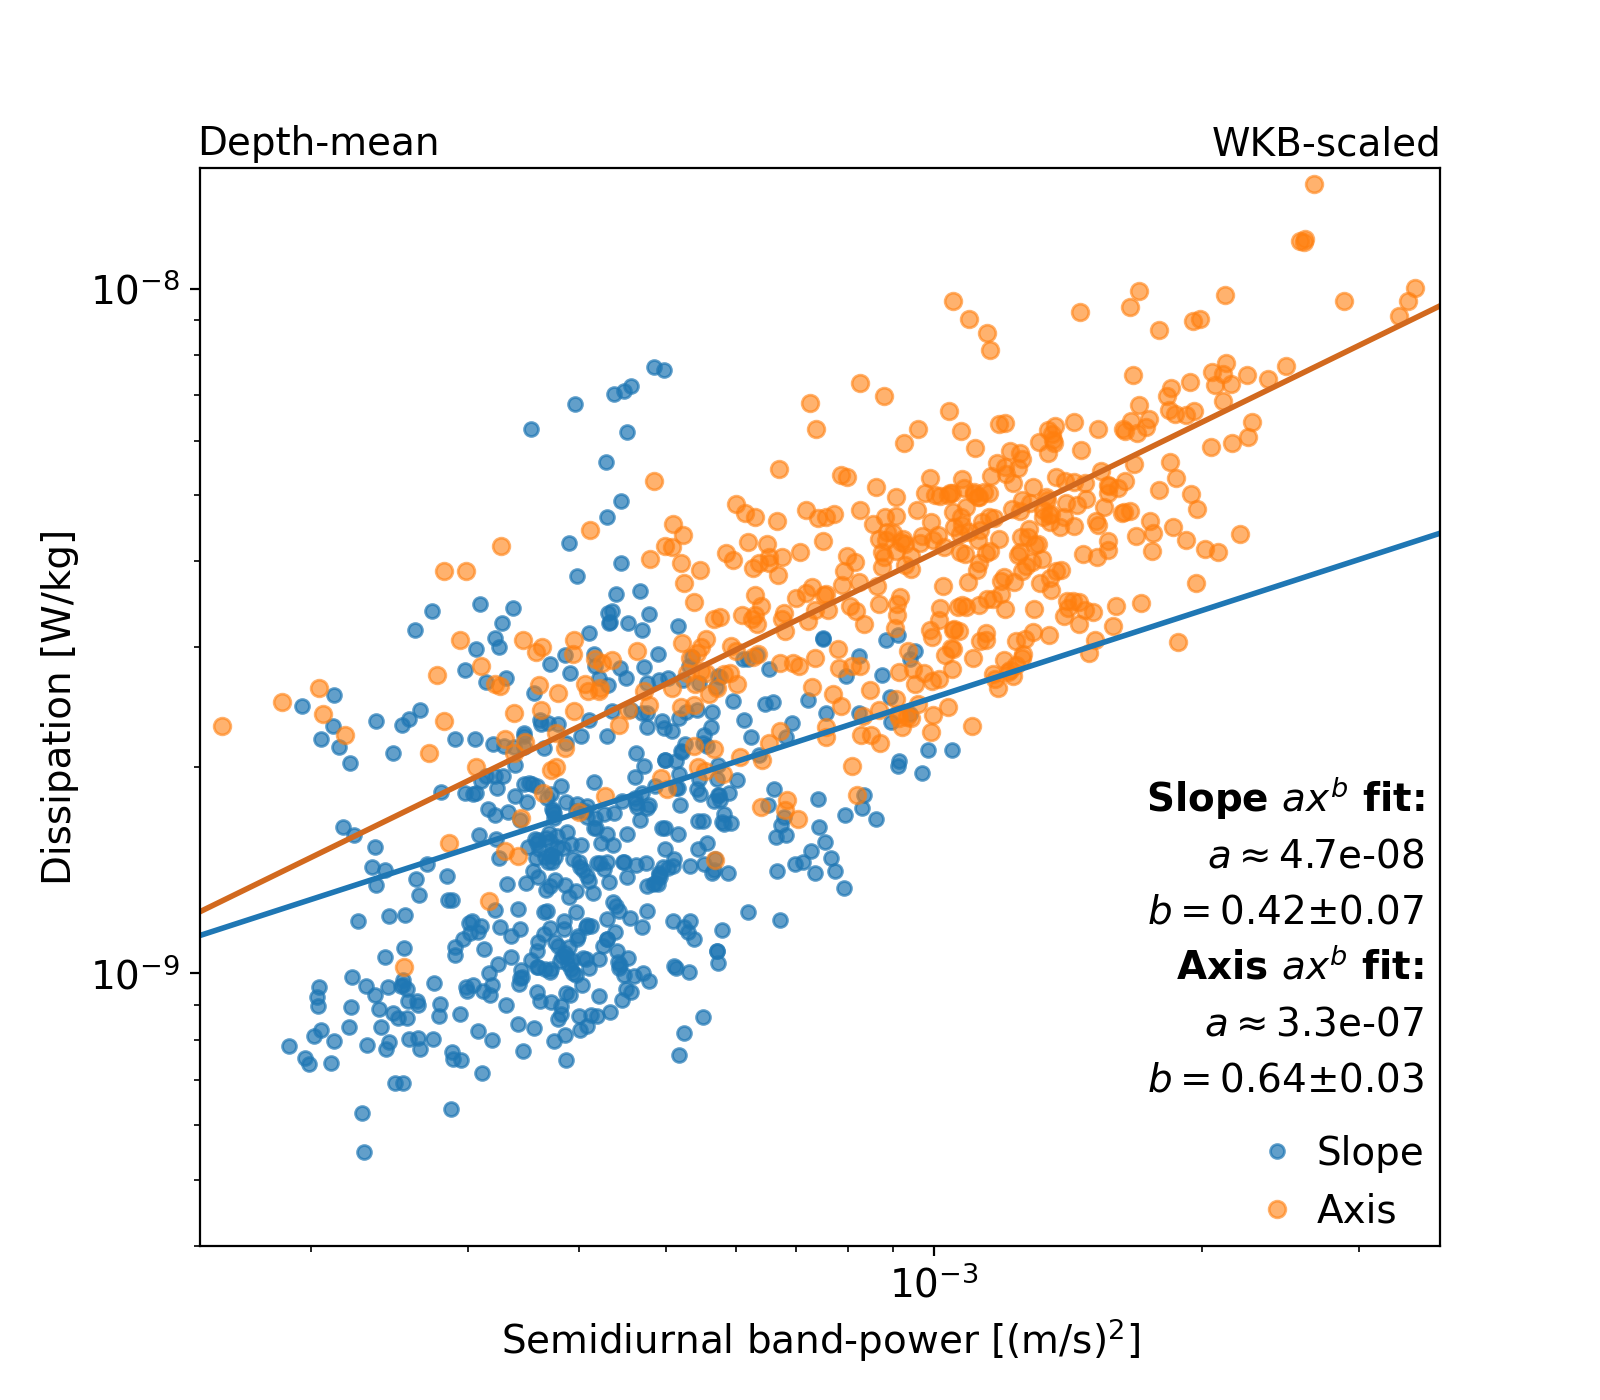

In [6]:
# plot epsilon vs power

fig,ax = plt.subplots(1,1,figsize=(8,7))

ax.plot(slope_U2_eps.U2,slope_U2_eps.eps,'o',ms=5,color='tab:blue',label='Slope',alpha=0.7)#,markeredgecolor='black')
ax.plot(axis_U2_eps.U2,axis_U2_eps.eps,'o',ms=6,color='tab:orange',label='Axis',alpha=0.6)#,markeredgecolor='black')
    
ax.set_yscale('log')
ax.set_xscale('log')

if band2 == 'Subdiurnal':
    ax.set_ylim(4e-10,1.5e-8)
    ax.set_xlim(0.95e-4,2.5e-3)
elif band2 == 'Diurnal':
    ax.set_ylim(4e-10,1.5e-8)
    ax.set_xlim(4e-5,1.5e-3)
elif band2 == 'Inertial':
    ax.set_ylim(4e-10,1.5e-8)
    ax.set_xlim(1e-4,4e-3)
elif band2 == 'Semidiurnal':
    ax.set_ylim(4e-10,1.5e-8)
    ax.set_xlim(1.5e-4,3.7e-3)
# ax.set_ylim(4e-10,1.5e-8)
# ax.set_xlim(4e-5,4e-3)

plrange = np.linspace(1e-5,1e-2,100)
ax.plot(plrange,slope_pars[0]*plrange**slope_pars[1],lw=2,color='tab:blue')
ax.plot(plrange,axis_pars[0]*plrange**axis_pars[1],lw=2,color='chocolate')

fig.text(0.89,0.42,r'Slope $ax^b$ fit:',fontsize=14,ha='right',fontweight='bold')
fig.text(0.89,0.38,r'$a\approx${:.1e}'.format(slope_pars[0]),fontsize=14,ha='right')
fig.text(0.89,0.34,r'$b=$%.2f$\pm$%.2f'%(slope_pars[1],np.sqrt(slope_cov[1,1])),fontsize=14,ha='right')
fig.text(0.89,0.30,r'Axis $ax^b$ fit:',fontsize=14,ha='right',fontweight='bold')
fig.text(0.89,0.26,r'$a\approx${:.1e}'.format(axis_pars[0]),fontsize=14,ha='right')
fig.text(0.89,0.22,r'$b=$%.2f$\pm$%.2f'%(axis_pars[1],np.sqrt(axis_cov[1,1])),fontsize=14,ha='right')

fig.text(0.123,0.889,'Depth-mean',fontsize=14,ha='left')
fig.text(0.901,0.889,'WKB-scaled',fontsize=14,ha='right')
    
ax.set_xlabel(fr'{band2} band-power [(m/s)$^2$]',fontsize=14)
ax.set_ylabel(f'Dissipation [W/kg]',fontsize=14)
#ax.set_title(f'{site}',fontsize=14)
ax.tick_params(labelsize=14,which='major')
ax.tick_params(labelsize=12,which='minor')
ax.legend(loc=[0.825,0],frameon=False,fontsize=14,handletextpad=0)
#fig.tight_layout()

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/continuum_pl_{band2}.pdf',format='pdf')

<IPython.core.display.Javascript object>


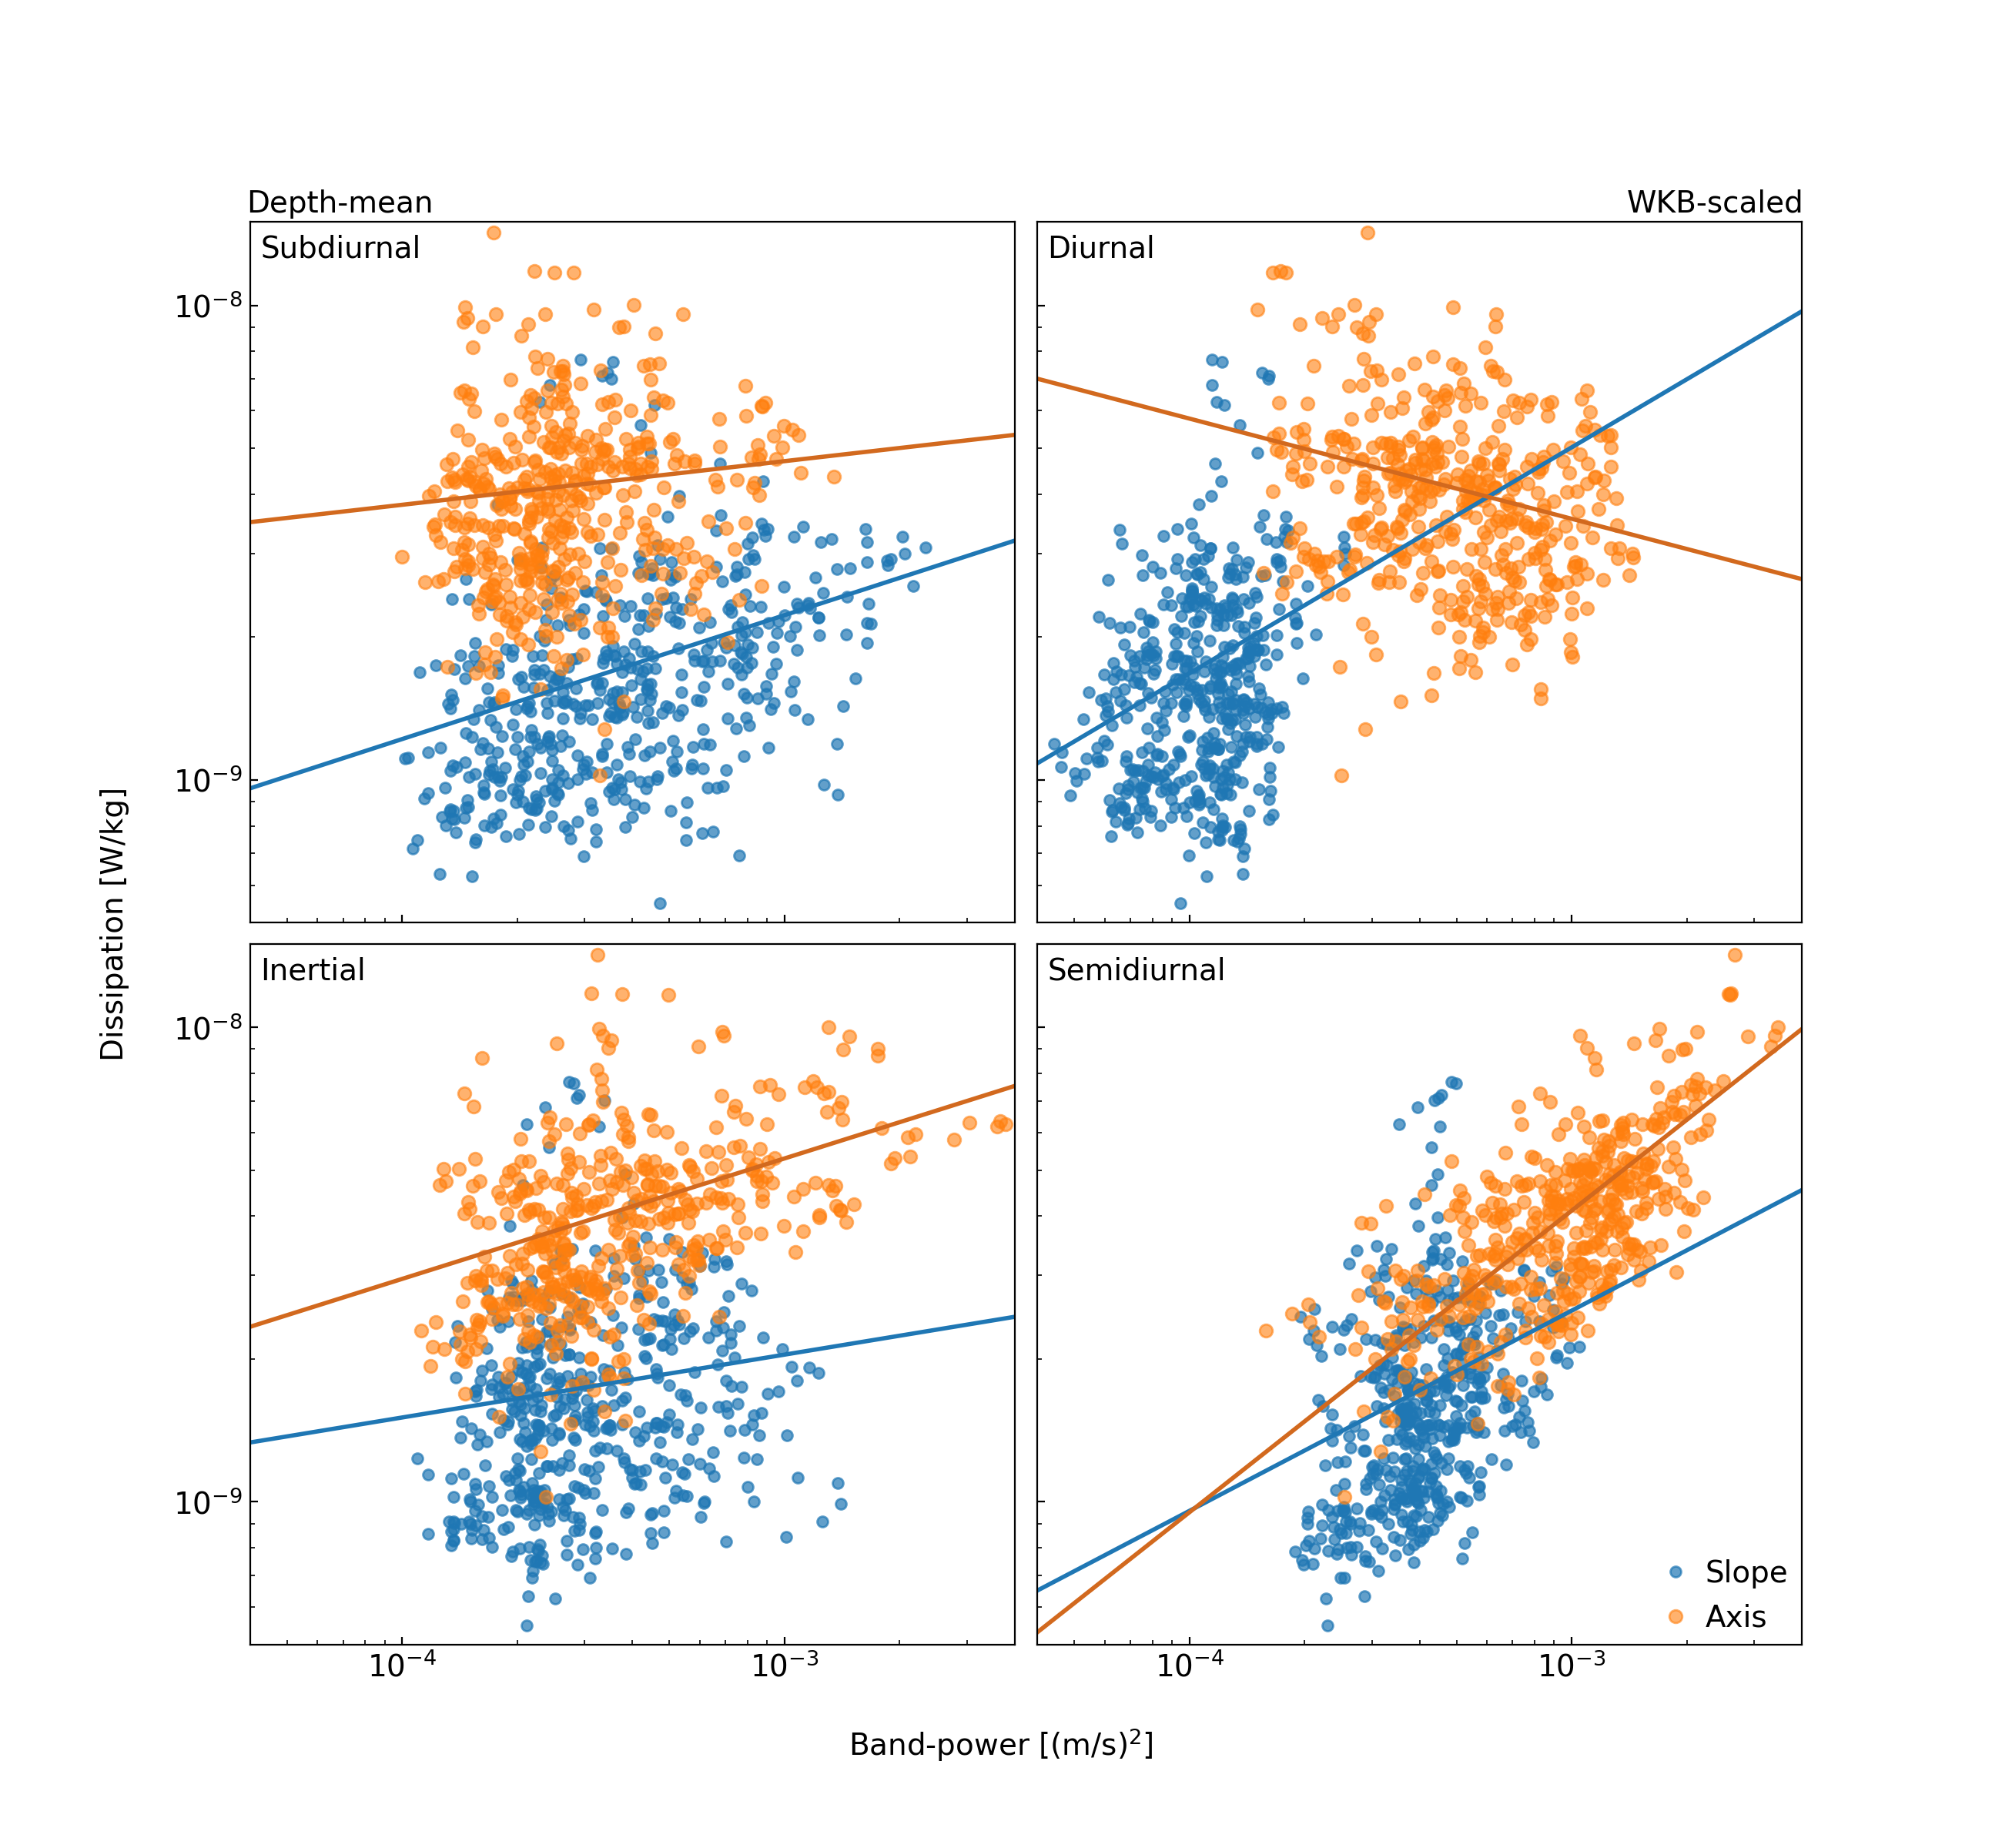

In [19]:
# plot all four constituents

# load data
for i in range(1):
    subdiurnal_slope = xr.open_dataset('../Data/data/cont/slope_U2_eps_Subdiurnal.nc')
    subdiurnal_axis = xr.open_dataset('../Data/data/cont/axis_U2_eps_Subdiurnal.nc')
    diurnal_slope = xr.open_dataset('../Data/data/cont/slope_U2_eps_Diurnal.nc')
    diurnal_axis = xr.open_dataset('../Data/data/cont/axis_U2_eps_Diurnal.nc')
    inertial_slope = xr.open_dataset('../Data/data/cont/slope_U2_eps_Inertial.nc')
    inertial_axis = xr.open_dataset('../Data/data/cont/axis_U2_eps_Inertial.nc')
    semidiurnal_slope = xr.open_dataset('../Data/data/cont/slope_U2_eps_Semidiurnal.nc')
    semidiurnal_axis = xr.open_dataset('../Data/data/cont/axis_U2_eps_Semidiurnal.nc')
    
    subdiurnal_slope_pars = np.load('../Data/data/cont/slope_pars_Subdiurnal.npy')
    subdiurnal_axis_pars = np.load('../Data/data/cont/axis_pars_Subdiurnal.npy')
    diurnal_slope_pars = np.load('../Data/data/cont/slope_pars_Diurnal.npy')
    diurnal_axis_pars = np.load('../Data/data/cont/axis_pars_Diurnal.npy')
    inertial_slope_pars = np.load('../Data/data/cont/slope_pars_Inertial.npy')
    inertial_axis_pars = np.load('../Data/data/cont/axis_pars_Inertial.npy')
    semidiurnal_slope_pars = np.load('../Data/data/cont/slope_pars_Semidiurnal.npy')
    semidiurnal_axis_pars = np.load('../Data/data/cont/axis_pars_Semidiurnal.npy')
    
    subdiurnal_slope_cov = np.load('../Data/data/cont/slope_cov_Subdiurnal.npy')
    subdiurnal_axis_cov = np.load('../Data/data/cont/axis_cov_Subdiurnal.npy')
    diurnal_slope_cov = np.load('../Data/data/cont/slope_cov_Diurnal.npy')
    diurnal_axis_cov = np.load('../Data/data/cont/axis_cov_Diurnal.npy')
    inertial_slope_cov = np.load('../Data/data/cont/slope_cov_Inertial.npy')
    inertial_axis_cov = np.load('../Data/data/cont/axis_cov_Inertial.npy')
    semidiurnal_slope_cov = np.load('../Data/data/cont/slope_cov_Semidiurnal.npy')
    semidiurnal_axis_cov = np.load('../Data/data/cont/axis_cov_Semidiurnal.npy')

# plot epsilon vs power

fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(13,12),sharex=True,sharey=True)

fig.subplots_adjust(hspace=0.03,wspace=0.03)

ax0.plot(subdiurnal_slope.U2,subdiurnal_slope.eps,'o',ms=5,color='tab:blue',label='Slope',alpha=0.7)
ax0.plot(subdiurnal_axis.U2,subdiurnal_axis.eps,'o',ms=6,color='tab:orange',label='Axis',alpha=0.6)
ax1.plot(diurnal_slope.U2,diurnal_slope.eps,'o',ms=5,color='tab:blue',label='Slope',alpha=0.7)
ax1.plot(diurnal_axis.U2,diurnal_axis.eps,'o',ms=6,color='tab:orange',label='Axis',alpha=0.6)
ax2.plot(inertial_slope.U2,inertial_slope.eps,'o',ms=5,color='tab:blue',label='Slope',alpha=0.7)
ax2.plot(inertial_axis.U2,inertial_axis.eps,'o',ms=6,color='tab:orange',label='Axis',alpha=0.6)
ax3.plot(semidiurnal_slope.U2,semidiurnal_slope.eps,'o',ms=5,color='tab:blue',label='Slope',alpha=0.7)
ax3.plot(semidiurnal_axis.U2,semidiurnal_axis.eps,'o',ms=6,color='tab:orange',label='Axis',alpha=0.6)
 
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_ylim(5e-10,1.5e-8)
ax0.set_xlim(4e-5,4e-3)

plrange = np.linspace(1e-5,1e-2,100)
ax0.plot(plrange,subdiurnal_slope_pars[0]*plrange**subdiurnal_slope_pars[1],lw=2,color='tab:blue')
ax0.plot(plrange,subdiurnal_axis_pars[0]*plrange**subdiurnal_axis_pars[1],lw=2,color='chocolate')
ax1.plot(plrange,diurnal_slope_pars[0]*plrange**diurnal_slope_pars[1],lw=2,color='tab:blue')
ax1.plot(plrange,diurnal_axis_pars[0]*plrange**diurnal_axis_pars[1],lw=2,color='chocolate')
ax2.plot(plrange,inertial_slope_pars[0]*plrange**inertial_slope_pars[1],lw=2,color='tab:blue')
ax2.plot(plrange,inertial_axis_pars[0]*plrange**inertial_axis_pars[1],lw=2,color='chocolate')
ax3.plot(plrange,semidiurnal_slope_pars[0]*plrange**semidiurnal_slope_pars[1],lw=2,color='tab:blue')
ax3.plot(plrange,semidiurnal_axis_pars[0]*plrange**semidiurnal_axis_pars[1],lw=2,color='chocolate')

fig.text(0.123,0.885,'Depth-mean',fontsize=14,ha='left')
fig.text(0.901,0.885,'WKB-scaled',fontsize=14,ha='right')
fig.text(0.05,0.5,f'Dissipation [W/kg]',fontsize=14,va='center',rotation='vertical')
fig.text(0.5,0.05,fr'Band-power [(m/s)$^2$]',fontsize=14,ha='center')
    
ax0.text(4.25e-5,1.26e-8,fr'Subdiurnal',fontsize=14)
ax1.text(4.25e-5,1.26e-8,fr'Diurnal',fontsize=14)
ax2.text(4.25e-5,1.26e-8,fr'Inertial',fontsize=14)
ax3.text(4.25e-5,1.26e-8,fr'Semidiurnal',fontsize=14)

ax0.tick_params(labelsize=14,which='both',direction='in')
ax1.tick_params(labelsize=14,which='both',direction='in')
ax2.tick_params(labelsize=14,which='both',direction='in')
ax3.tick_params(labelsize=14,which='both',direction='in')
ax3.legend(loc=[.78,0],frameon=False,fontsize=14,handletextpad=0)
#fig.tight_layout()

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/continuum_pl_all.pdf',format='pdf')

<IPython.core.display.Javascript object>


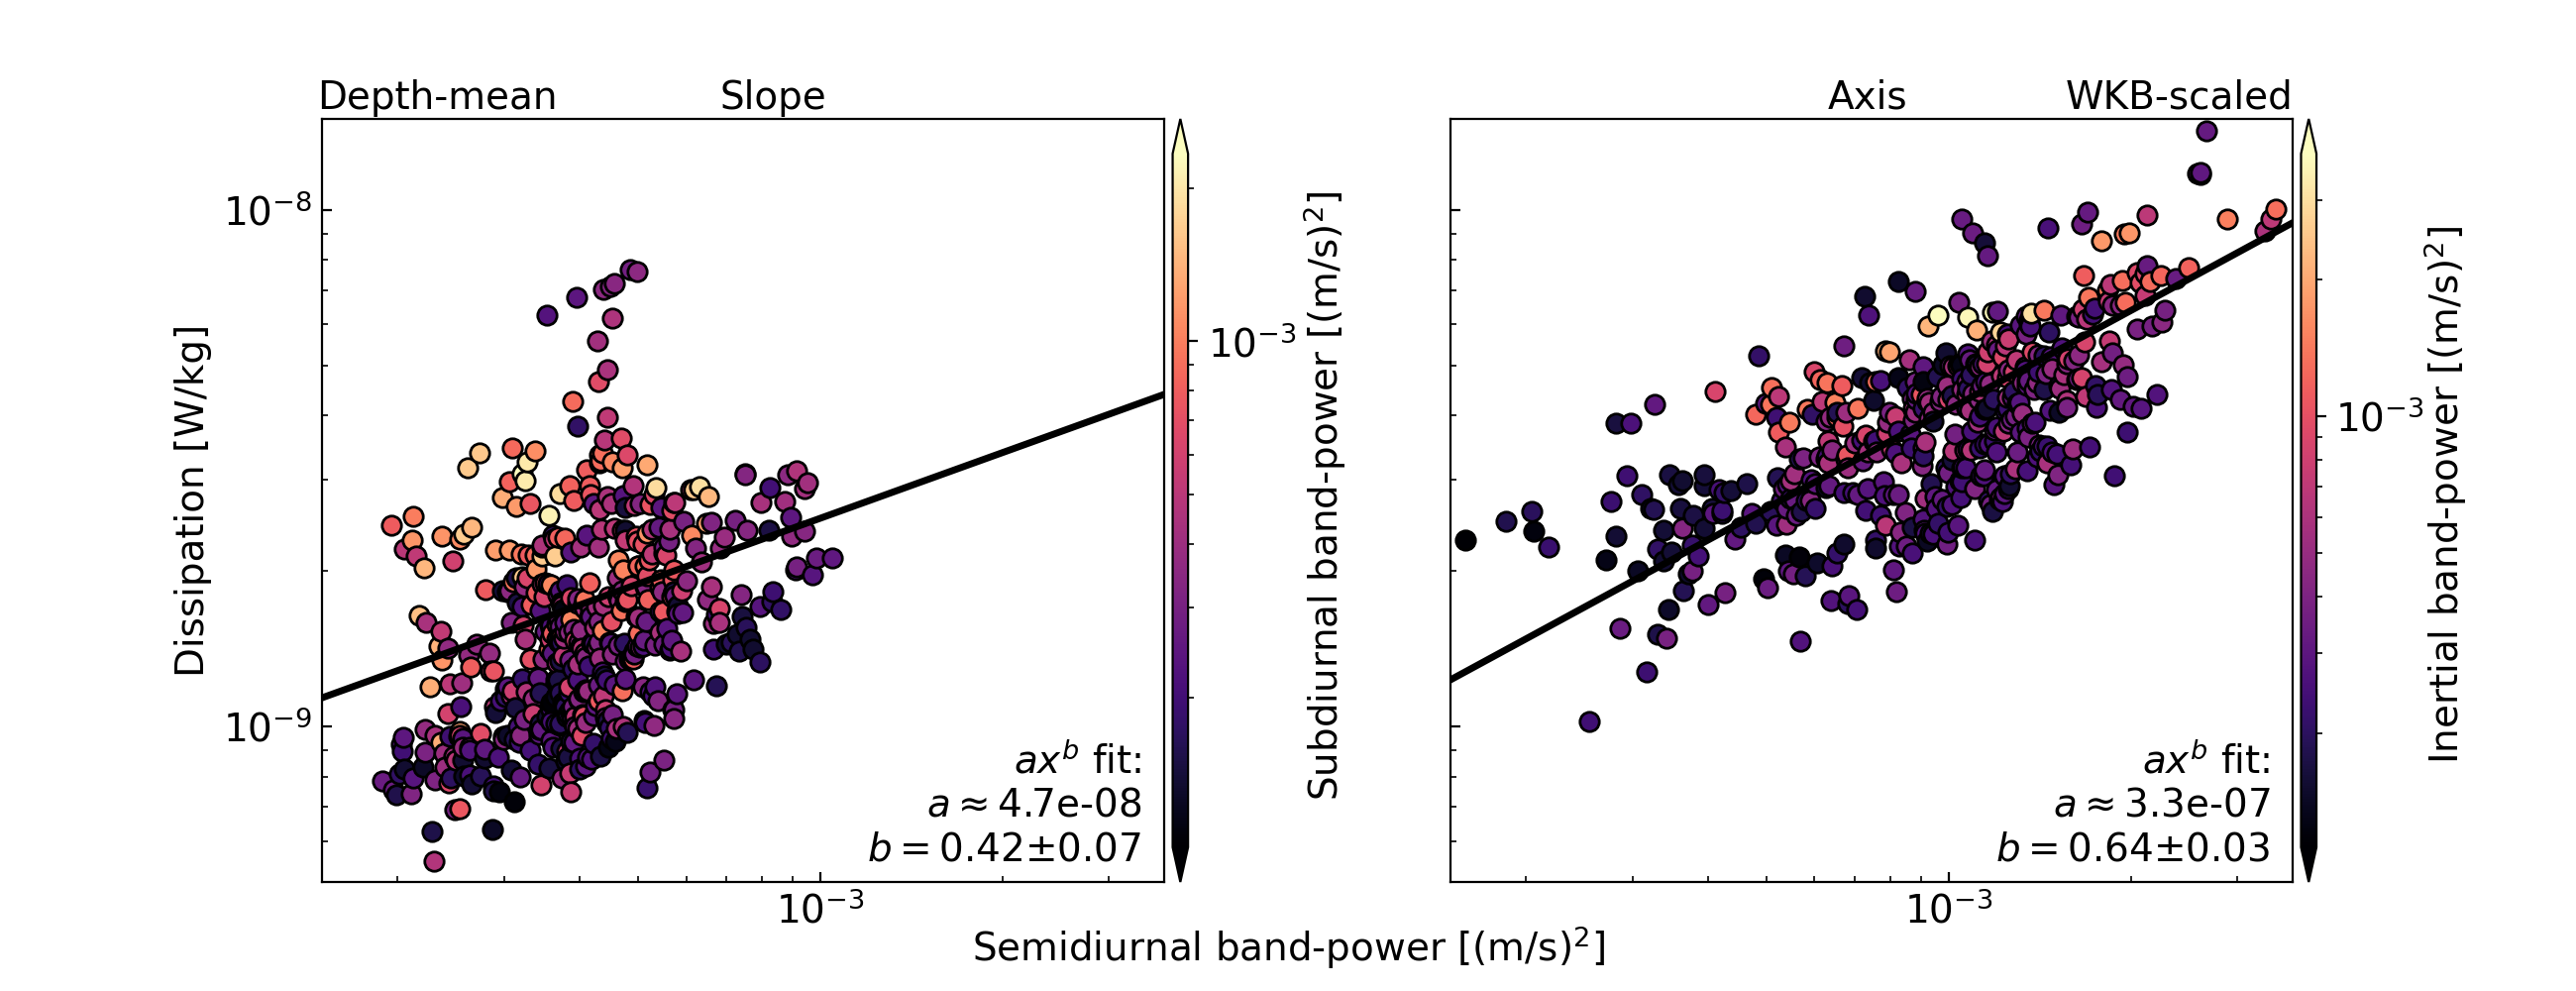

In [39]:
# plot site comparisons

# rgba values for secondary constituents

slope_grad,axis_grad = [],[]
slope_sub_min = np.min(semidiurnal_slope.sec.values)
slope_sub_max = np.max(semidiurnal_slope.sec.values)
axis_sub_min = np.min(semidiurnal_axis.sec.values)
axis_sub_max = np.max(semidiurnal_axis.sec.values)
cmapx = 'magma'
plasma_log_slope = cm.ScalarMappable(norm=colors.LogNorm(vmin=slope_sub_min,vmax=slope_sub_max),cmap=cmapx)
plasma_log_axis = cm.ScalarMappable(norm=colors.LogNorm(vmin=axis_sub_min,vmax=axis_sub_max),cmap=cmapx)

for i in range(len(semidiurnal_slope.sec)):
    slope_grad.append(plasma_log_slope.to_rgba(semidiurnal_slope.sec[i].values))
for i in range(len(semidiurnal_axis.sec)):
    axis_grad.append(plasma_log_axis.to_rgba(semidiurnal_axis.sec[i].values))

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(13,5),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.3)

# plot

for i in range(len(slope_grad)):
    im0 = ax0.plot(semidiurnal_slope.U2[i],semidiurnal_slope.eps[i],'o',ms=7,color=slope_grad[i],label='Slope',markeredgecolor='black',alpha=1)
for i in range(len(axis_grad)):
    im1 = ax1.plot(semidiurnal_axis.U2[i],semidiurnal_axis.eps[i],'o',ms=7,color=axis_grad[i],label='Axis',markeredgecolor='black',alpha=1)

norm0 = colors.LogNorm(vmin=np.min(semidiurnal_slope.sec.values),vmax=slope_sub_max)
cbar0 = fig.colorbar(pl.cm.ScalarMappable(norm=norm0,cmap=cmapx), ax=ax0, fraction=0.02, pad=0.01, aspect=45, extend='both')
cbar0.ax.tick_params(labelsize=14)
norm1 = colors.LogNorm(vmin=np.min(semidiurnal_axis.sec.values),vmax=axis_sub_max)
cbar1 = fig.colorbar(pl.cm.ScalarMappable(norm=norm1,cmap=cmapx), ax=ax1, fraction=0.02, pad=0.01, aspect=45, extend='both')
cbar1.ax.tick_params(labelsize=14)
   
    
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_ylim(5e-10,1.5e-8)
ax0.set_xlim(1.5e-4,3.7e-3)

plrange = np.linspace(1e-5,1e-2,100)
ax0.plot(plrange,semidiurnal_slope_pars[0]*plrange**semidiurnal_slope_pars[1],lw=2.5,color='black')
ax1.plot(plrange,semidiurnal_axis_pars[0]*plrange**semidiurnal_axis_pars[1],lw=2.5,color='black')

ax0.text(3.4e-3,8.1e-10,r'$ax^b$ fit:',fontsize=14,ha='right')
ax0.text(3.4e-3,6.7e-10,r'$a\approx${:.1e}'.format(semidiurnal_slope_pars[0]),fontsize=14,ha='right')
ax0.text(3.4e-3,5.5e-10,r'$b=$%.2f$\pm$%.2f'%(semidiurnal_slope_pars[1],np.sqrt(semidiurnal_slope_cov[1,1])),fontsize=14,ha='right')
ax1.text(3.4e-3,8.1e-10,r'$ax^b$ fit:',fontsize=14,ha='right')
ax1.text(3.4e-3,6.7e-10,r'$a\approx${:.1e}'.format(semidiurnal_axis_pars[0]),fontsize=14,ha='right')
ax1.text(3.4e-3,5.5e-10,r'$b=$%.2f$\pm$%.2f'%(semidiurnal_axis_pars[1],np.sqrt(semidiurnal_axis_cov[1,1])),fontsize=14,ha='right')

fig.text(0.123,0.89,'Depth-mean',fontsize=14,ha='left')
fig.text(0.89,0.89,'WKB-scaled',fontsize=14,ha='right')
fig.text(0.30,0.89,'Slope',fontsize=14,ha='center')
fig.text(0.725,0.89,'Axis',fontsize=14,ha='center')
ax0.set_ylabel(f'Dissipation [W/kg]',fontsize=14)
#ax1.set_ylabel(f'Dissipation [W/kg]',fontsize=14)
fig.text(0.5,0.03,fr'Semidiurnal band-power [(m/s)$^2$]',fontsize=14,ha='center')
fig.text(0.505,0.5,fr'Subdiurnal band-power [(m/s)$^2$]',rotation='vertical',fontsize=14,va='center')
fig.text(0.94,0.5,fr'Inertial band-power [(m/s)$^2$]',rotation='vertical',fontsize=14,va='center')

ax0.tick_params(labelsize=14,which='both',direction='in')
ax1.tick_params(labelsize=14,which='both',direction='in')
#fig.tight_layout()

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/continuum_pl_compare.pdf',format='pdf')

### Correlations - uses import from beginning of 1.8 Seasonality Comparisons

In [ ]:
# segment and correlate

start_dates,end_dates = [],[]
for i in years:
    start_dates.append( np.array([f'{i[0].t_stamp}-01-05',f'{i[0].t_stamp}-04-03',\
                                  f'{i[0].t_stamp}-07-03',f'{i[0].t_stamp}-10-03'],dtype='datetime64[ns]') )
    end_dates.append( np.array([f'{i[0].t_stamp}-03-30',f'{i[0].t_stamp}-06-29',\
                                  f'{i[0].t_stamp}-09-29',f'{i[0].t_stamp}-12-25'],dtype='datetime64[ns]') )
if site == 'Slope':
    start_dates[2][2] = np.datetime64('2017-07-25')
    end_dates[2][1] = np.datetime64('2017-06-25')
    end_dates[3][3] = np.datetime64('2018-11-14')
elif site == 'Axis':
    start_dates[0][1] = np.datetime64('2019-07-25')
    end_dates[0][1] = np.datetime64('2019-06-25')
    start_dates[1][1] = np.datetime64('2019-05-20')
    end_dates[1][1] = np.datetime64('2019-06-25')
    start_dates[2][2] = np.datetime64('2017-07-20')
    start_dates[1][0] = np.datetime64('2019-07-25')
    end_dates[1][0] = np.datetime64('2019-06-25')
    end_dates[3][1] = np.datetime64('2018-06-05')
    start_dates[3][2] = np.datetime64('2019-07-25')
    end_dates[3][2] = np.datetime64('2019-06-25')
    start_dates[3][3] = np.datetime64('2019-07-25')
    end_dates[3][3] = np.datetime64('2019-06-25')
    
corrU,SEr = [],[]
for i,j in enumerate(years):
    corr_temp,corrunc = [],[]
    for k in range(j[0].n_seg):
        seg_temp,segunc_temp = [],[]
        for l in range(len(start_dates)):
            seg_temp.append( float(xr.corr(U_avg[i][k].sel(spect_s=slice(start_dates[i][l],end_dates[i][l])),\
                                    U_avg2[i][k].sel(spect_s=slice(start_dates[i][l],end_dates[i][l]))).values)  )
            N = len(U_avg[i][k].sel(spect_s=slice(start_dates[i][l],end_dates[i][l])))
            if N == 2:
                N = 3
            segunc_temp.append(np.sqrt( (1 - (abs(seg_temp[l])**2))/(N-2) ))
        if seg_temp[0] == np.nan:
            continue
        else:    
            corr_temp.append(seg_temp)
            corrunc.append(segunc_temp)
    corrU.append(corr_temp)
    SEr.append(corrunc)

In [ ]:
# plot correlation data

fig, [ax0,ax1,ax2,ax3] = plt.subplots(4,1,figsize=(12,7),sharex=False,sharey=True)

axes = [ax0,ax1,ax2,ax3]

if band2 == 'Semidiurnal':
    if site == 'Slope':
        testy=[0.0001,0.0001]
        mult = 7
        ry = -0.00007
        offset = -0.00025
        ax3.set_ylim(-0.00012,0.0011)
    elif site == 'Axis':
        testy=[0.0001,0.0001]
        mult = 14
        ry = -0.00042
        offset = -0.0007
        ax3.set_ylim(-0.0008,0.0035)
elif band2 == 'Inertial':
    if site == 'Slope':
        testy=[0.000,0.000]
        mult = 10
        ry = -0.00025
        offset = -0.0005
        ax3.set_ylim(-0.0003,0.0015)
    elif site == 'Axis':
        testy=[-0.0003,-0.0003]
        mult = 12
        ry = -0.0007
        offset = -0.0011
        ax3.set_ylim(-0.0008,0.0021)
elif band2 == 'Subdiurnal':
    if site == 'Slope':
        testy=[0.000,0.000]
        mult = 20
        ry = -0.00045
        offset = -0.0011
        ax3.set_ylim(-0.0006,0.0027)
    elif site == 'Axis':
        testy=[-0.0003,-0.0003]
        mult = 12
        ry = -0.0007
        offset = -0.0011
        ax3.set_ylim(-0.0008,0.0021)
elif band2 == 'Diurnal':
    if site == 'Slope':
        testy=[0.00003,0.00003]
        mult = 2
        ry = -0.000014
        offset = -0.00008
        ax3.set_ylim(-0.00003,0.0003)
    elif site == 'Axis':
        testy=[-0.0003,-0.0003]
        mult = 12
        ry = -0.0007
        offset = -0.0011
        ax3.set_ylim(-0.0008,0.002)
        
for i,j in enumerate(years):
    for k in range(j[0].n_seg):
        for l in range(len(start_dates)):
            axes[i].plot([start_dates[i][l],end_dates[i][l]],testy,color='black',lw=2)
            if np.isnan(corrU[i][k][l]) == False:
                axes[i].text(start_dates[i][l],ry,rf'r$_{l+1}$ = %.2f $\pm$ %.2f' % (corrU[i][k][l], SEr[i][k][l]),fontsize=13) 

for i,j in enumerate(years):
    if site == 'Axis' and i == 2:
        offset = 2*offset
    for k in range(j[0].n_seg):
        if k == 0:
            axes[i].plot(U_avg[i][k].spect_s,(U_avg[i][k]*mult)+offset,color='tab:blue',label='Continuum')#label=f'Corr. {k} = %1.2f' % corr_temp )
            axes[i].plot(U_avg2[i][k].spect_s,U_avg2[i][k],color='tab:orange',label=f'{band2}')
            axes[i].set_xlim(np.datetime64(f'{years[i][k].t_stamp}-01-01'),np.datetime64(f'{str(int(years[i][k].t_stamp)+1)}-01-01'))
        elif k > 0:
            axes[i].plot(U_avg[i][k].spect_s,(U_avg[i][k]*mult)+offset,color='tab:blue')#label=f'Corr. {k} = %1.2f' % corr_temp )
            axes[i].plot(U_avg2[i][k].spect_s,U_avg2[i][k],color='tab:orange')

fig.text(0.51,0.887,f'{site}',ha='center',fontsize=14)
fig.text(0.145,0.885,f'2013',ha='center',fontsize=14)
fig.text(0.85,0.885,f'Depth-mean',ha='center',fontsize=14)
fig.text(0.145,0.68,f'2014',ha='center',fontsize=14)
fig.text(0.145,0.48,f'2017',ha='center',fontsize=14)
fig.text(0.145,0.28,f'2018',ha='center',fontsize=14)
fig.text(0.51,0.04,f'Months [mm]',ha='center',fontsize=14)
fig.text(0.09,0.5,r'Band power [scaled]',va='center',rotation='vertical',fontsize=14)

date_form = pldates.DateFormatter("%m")
for i in axes:
    i.xaxis.set_major_formatter(date_form)
    i.tick_params(labelsize=14)
    i.axes.yaxis.set_ticks([])
ax0.axes.xaxis.set_ticks([])
ax1.axes.xaxis.set_ticks([])
ax2.axes.xaxis.set_ticks([])

ax3.legend(fontsize=14,frameon=False,ncol=2,loc='upper center',borderpad=0)
plt.show()

plt.savefig(fname=f'./plots/interannual_plots/continuum_corr_{band2}_{site}.pdf',format='pdf')

In [ ]:
# plot comparison data

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
fig.subplots_adjust(hspace = 0.25)

fig.text(0.51, 0.92, f'Continuum-{band2} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.884, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.884, '2013', ha='center',fontsize=14)
fig.text(0.544, 0.884, '2014', ha='center',fontsize=14)
#fig.text(0.142, 0.683, '2013', ha='center',fontsize=14)
#fig.text(0.544, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.479, '2017', ha='center',fontsize=14)
fig.text(0.544, 0.479, '2018', ha='center',fontsize=14)
#fig.text(0.142, 0.281, '2017', ha='center',fontsize=14)
#fig.text(0.544, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Continuum':  
    fig.text(0.31, 0.884, 'Continuum', ha='center', fontsize=14)
    fig.text(0.71, 0.884, 'Continuum', ha='center', fontsize=14)
    fig.text(0.31, 0.479, 'Continuum', ha='center', fontsize=14)
    fig.text(0.71, 0.479, 'Continuum', ha='center', fontsize=14)
    fig.text(0.48, 0.884, 'Total', ha='center', fontsize=14)
    if site == 'Axis':
        vmin = 1e-4
        vmax = 4e-4
    elif site == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
 
if band2 == 'Diurnal':
    fig.text(0.31, 0.681, 'Diurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.681, 'Diurnal', ha='center', fontsize=14)
    fig.text(0.31, 0.277, 'Diurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.277, 'Diurnal', ha='center', fontsize=14)
    if site == 'Axis':
        vmin2 = 3e-5
        vmax2 = 5e-3
    elif site == 'Slope':
        vmin2 = 3e-5
        vmax2 = 5e-4
elif band2 == 'Inertial':  
    fig.text(0.31, 0.681, 'Inertial', ha='center', fontsize=14)
    fig.text(0.71, 0.681, 'Inertial', ha='center', fontsize=14)
    fig.text(0.31, 0.277, 'Inertial', ha='center', fontsize=14)
    fig.text(0.71, 0.277, 'Inertial', ha='center', fontsize=14)
    if site == 'Axis':
        vmin2 = 6e-5
        vmax2 = 5e-3
    elif site == 'Slope':
        vmin2 = 6e-5
        vmax2 = 5e-3
elif band2 == 'Semidiurnal':  
    fig.text(0.31, 0.681, 'Semidiurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.681, 'Semidiurnal', ha='center', fontsize=14)
    fig.text(0.31, 0.277, 'Semidiurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.277, 'Semidiurnal', ha='center', fontsize=14)
    if site == 'Axis':
        vmin2 = 1e-4
        vmax2 = 5e-3
    elif site == 'Slope':
        vmin2 = 6e-5
        vmax2 = 3e-3
elif band2 == 'Subdiurnal':  
    fig.text(0.31, 0.681, 'Subdiurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.681, 'Subdiurnal', ha='center', fontsize=14)
    fig.text(0.31, 0.277, 'Subdiurnal', ha='center', fontsize=14)
    fig.text(0.71, 0.277, 'Subdiurnal', ha='center', fontsize=14)
    if site == 'Axis':
        vmin2 = 1e-4
        vmax2 = 5e-3
        #fig.text(0.71, 0.886, 'Subdiurnal', ha='center', fontsize=14)
        #fig.text(0.544, 0.886, 'Total', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin2 = 1e-4
        vmax2 = 5e-3
        #fig.text(0.544, 0.886, 'Total', ha='center', fontsize=14)

date_form = pldates.DateFormatter("%m")

years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            ax0.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            ax4.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            ax5.xaxis.set_major_formatter(date_form)

years2 = [ds2_2013,ds2_2014,ds2_2017,ds2_2018] 
for k,i in enumerate(years2):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin2, vmax=vmax2), cmap='plasma', shading='auto')  
            ax2.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin2, vmax=vmax2), cmap='plasma', shading='auto')  
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin2, vmax=vmax2), cmap='plasma', shading='auto')  
            ax6.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, np.sqrt(i[j].u_WKB**2 + i[j].v_WKB**2), rasterized=True, \
                norm=colors.LogNorm(vmin=vmin2, vmax=vmax2), cmap='plasma', shading='auto')  
            ax7.xaxis.set_major_formatter(date_form)
            
            
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax2]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-700, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax1,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-700, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax6]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-700, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax5,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-700, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
if site == 'Slope':
    ax7.set_ylim(-ds_2013[0].depth[-1],0)
elif site == 'Axis':
    ax7.set_ylim(None,-600)
    
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

fig.add_artist(lines.Line2D([0.5125, 0.5125], [0.11, 0.88],color='black'))
fig.add_artist(lines.Line2D([0.125, 0.877], [0.5025, 0.5025],color='black'))    
    
plt.show()

plt.savefig(fname=f'./plots/interannual_plots/continuum_cascade_{band2}_{site}.pdf',format='pdf')